# Supervised learning project: finding donors for *CharityML*

This project was completed as part of Udacity's Machine Learning Nanodegree.

In this project, we will employ several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. We will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Our goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations. Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with. While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The dataset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


In [2]:
#Checking out the datatypes of the features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
age                45222 non-null int64
workclass          45222 non-null object
education_level    45222 non-null object
education-num      45222 non-null float64
marital-status     45222 non-null object
occupation         45222 non-null object
relationship       45222 non-null object
race               45222 non-null object
sex                45222 non-null object
capital-gain       45222 non-null float64
capital-loss       45222 non-null float64
hours-per-week     45222 non-null float64
native-country     45222 non-null object
income             45222 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [3]:
# TODO: Total number of records
n_records= data.shape[0]

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k= len(data[data['income']=='>50K'])

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k= len(data[data['income']=='<=50K'])

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent= n_greater_50k/n_records*100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

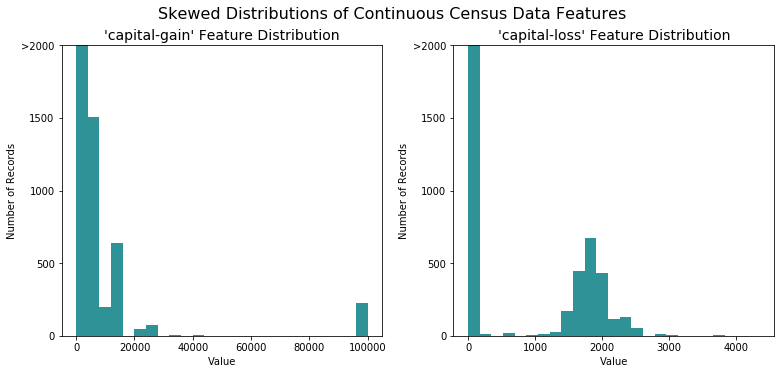

In [4]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

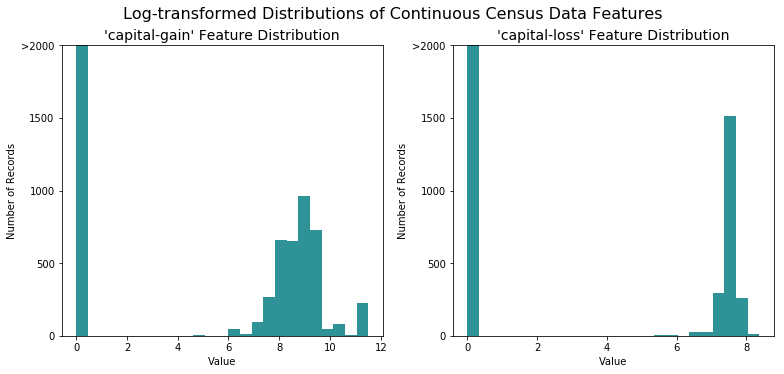

In [5]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [6]:
# Import sklearn.preprocessing.MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head())

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.00000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.00000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.00000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [7]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
features= pd.get_dummies(features_raw)

# TODO: Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x: 1 if x == '>50K' else 0)

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
# print(encoded)

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [8]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [9]:
# for a model that always predicts an individual makes more than \$50,000

# TODO: Calculate accuracy
accuracy= n_greater_50k/n_records

# TODO: Calculate F-score using the formula above for beta = 0.5
true_pos= n_greater_50k
true_neg= n_at_most_50k
false_pos= n_records-n_greater_50k
false_neg= 0
precision= true_pos/(true_pos+false_pos)
recall= true_pos/(true_pos+false_neg)
beta= 0.5
fscore= (1+beta**2)*(precision*recall)/(beta**2*precision+recall)

# Print the results 
print("Naive Predictor \nAccuracy score: {:.4f}\nF-score: {:.4f}".format(accuracy, fscore))

Naive Predictor 
Accuracy score: 0.2478
F-score: 0.2917


###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
    - Works well with large feature spaces. 
    - Fits data to a Gaussian distribution. 
    - Remember distribution from above, not exactly Gaussian due to large number at extreme left tail. 
    - Also doesn't really make sense to fit a Gaussian model to features which are one-hot encoded.
- Decision Trees
    - Quite fast.
    - Prone to overfitting. 
    - Handle mixed features (categorical and numerical) well. 
    - Ignores redundant variables. 
    - Optimizes for information gain. 
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
    - Reduce tendency to overfit.
    - Same benefits as decision trees.
- K-Nearest Neighbors (KNeighbors)
    - Large variance in performance results based on tuning parameters. 
- Stochastic Gradient Descent Classifier (SGDC)
    - Flexible approach, can use any convex loss function. 
- Support Vector Machines (SVM)
    - Doesn't perform exceptionally well with noisy datasets. 
    - Slow to train on large datasets. 
- Logistic Regression
    - Simple, easy to train approach. 

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Answer**:

- **AdaBoost**:
    - *Describe one real-world application in industry where the model can be applied.* AdaBoost, short for Adaptive Boosting, is commonly used in computer vision (object detection, face recognition etc.) [Reference: Basketball player detection](https://www.uni-obuda.hu/journal/Markoski_Ivankovic_Ratgeber_Pecev_Glusac_57.pdf) It is also a favourite in Kaggle competitions!
    - *What are the strengths of the model; when does it perform well?* This model involves a selection of the most relevant features during the training process. Only the features that actually improve the performance of the model will be selected. Therefore, AdaBoost is computationally fast and its speed makes it a good choice for real-time applications such as speech recognition.
    - *What are the weaknesses of the model; when does it perform poorly?* Outliers and noisy data reduce the performance of this model.
    - *What makes this model a good candidate for the problem, given what you know about the data?* AdaBoost is a strong learner that works well on both basic and complex classification problems. We now have quite a lot of features in this project but it will not be a problem for this model as it will select the most relevant ones.


- **SVM**:
    - *Describe one real-world application in industry where the model can be applied.* SVM is used in a wide range of contexts such as image classification, bioinformatics (cancer classification, etc.) and hand-written character recognition. [Reference: face detection](http://www.cmlab.csie.ntu.edu.tw/~cyy/learning/papers/SVM_FaceCVPR1997.pdf)
    - *What are the strengths of the model; when does it perform well?* This model can perform linear classification but its real strength lies in its ability to efficiently handle high-dimensional feature spaces. Plus, it is a versatile model that can be customised to adapt to a wide range of classification problems.
    - *What are the weaknesses of the model; when does it perform poorly?* Very large datasets make SVM slow to train. This model is also sensitive to noisy data.
    - *What makes this model a good candidate for the problem, given what you know about the data?* SVM will handle the large number of features that we now have in this project efficiently. The size of our dataset should not be a problem for SVM.


- **Stochastic Gradient Descent Classifier**:
    - *Describe one real-world application in industry where the model can be applied.* SGD is very much used in the field of natural language processing. Note: Amazon actually uses SGD for multiclass classification as part of its AWS Machine Learning service. [Reference: AWS](https://docs.aws.amazon.com/machine-learning/latest/dg/learning-algorithm.html)
    - *What are the strengths of the model; when does it perform well?* One of the main reasons to use SGD is that it performs very well under large scale settings. [Reference: large scale](http://stochastic.csa.iisc.ernet.in/~saswata/documents/termreport.pdf)
    - *What are the weaknesses of the model; when does it perform poorly?* SGD requires hyperparameter fine-tuning and is sensitive to feature scaling.
    - *What makes this model a good candidate for the problem, given what you know about the data?* Our data has been scaled during preprocessing and is suitable for SGD which should perform well with a dataset of this size.

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [10]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    # Create empty dictionary to store results in later.
    results= {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start_train= time() # Get start time
    learner= learner.fit(X_train[:sample_size],y_train[:sample_size])
    end_train= time() # Get end time
    
    # TODO: Calculate the training time
    results["train_time"]= end_train-start_train
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start_pred= time()# Get start time
    pred_test= learner.predict(X_test)
    pred_train= learner.predict(X_train[:300])
    end_pred= time() # Get end time
    
    # TODO: Calculate the total prediction time
    results["pred_time"]= end_pred-start_pred
    
    # TODO: Compute accuracy on the first 300 training samples
    results["acc_train"]= accuracy_score(y_train[:300],pred_train)
        
    # TODO: Compute accuracy on test set
    results["acc_test"]= accuracy_score(y_test,pred_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    beta= 0.5
    results["f_train"]= fbeta_score(y_train[:300],pred_train,beta)
        
    # TODO: Compute F-score on the test set
    results["f_test"]= fbeta_score(y_test,pred_test,beta)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.
SGDClassifier trained on 361 samples.
SGDClassifier trained on 3617 samples.
SGDClassifier trained on 36177 samples.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


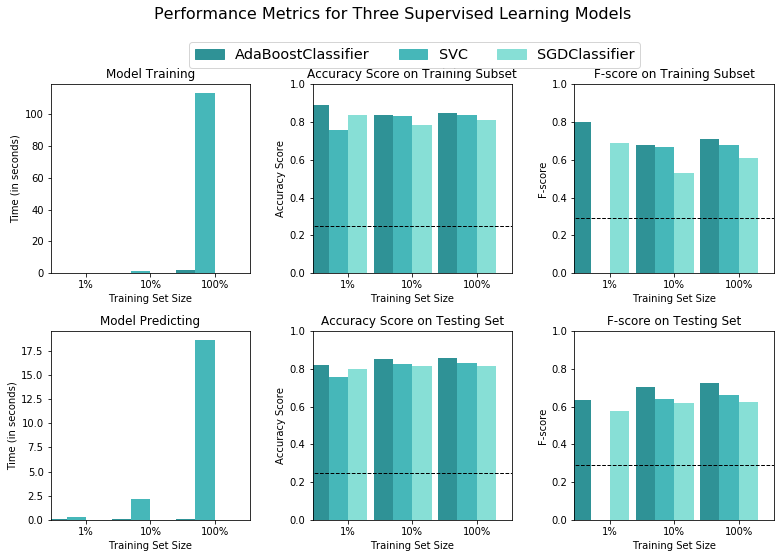

In [11]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn import linear_model

# TODO: Initialize the three models
clf_A= AdaBoostClassifier(random_state=2)
clf_B= SVC(random_state=2)
clf_C= linear_model.SGDClassifier(random_state=2)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1= int(len(X_train)*0.01)
samples_10= int(len(X_train)*0.1)
samples_100= len(X_train)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)
        
# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

Note that the SVM f-score cannot be computed and returns 0 for the 1% sample because the size is too small and we effectively end up dividing by 0 [Reference](https://stackoverflow.com/questions/34757653/why-does-scikitlearn-says-f1-score-is-ill-defined-with-fn-bigger-than-0/34758800#34758800).

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

**Answer**:

Based on the results above, I would recommend the AdaBoost classifier. CharityML might not consider speed to be a priority but I would anyway start by pointing out that, unlike SVM, AdaBoost is fast at both training and predicting and would therefore scale well. More importantly for the charity, the accuracy score and the F-score of this model are consistently high for the different dataset sizes. Plus, these scores are similar for the training subset and the testing set, suggesting that this model is not overfitting and will generalise well to unseen data.

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer**:

In order to predict whether or not an individual earns more than 50K, we have chosen an algorithm called AdaBoost. It is a strong predictor that relies on the combination of simple learners. Using the available features, such as the age and the education level of an individual, each learner defines a set of rules that should accurately predict the income of that person. Initially, some learners will make wrong predictions but AdaBoost will use these mistakes to tweak the subsequent learners. At the end of the training process of the algorithm, we end up with an ensemble of learners. Separately, these simple learners would not make very accurate predictions, but their combination by AdaBoost achieves a greatly improved overall performance.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [12]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer

# TODO: Initialize the classifier
clf = AdaBoostClassifier(random_state=0)

# initialising decision trees with different max_depth
from sklearn.tree import DecisionTreeClassifier
dt1= DecisionTreeClassifier(max_depth=2)
dt2= DecisionTreeClassifier(max_depth=5)

# TODO: Create the parameters list you wish to tune
parameters= {'base_estimator': [dt1, dt2],
            'n_estimators': [50, 100, 120],
            'learning_rate': [0.1, 0.5, 1.0]}

# TODO: Make an fbeta_score scoring object
scorer= make_scorer(fbeta_score,beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj= GridSearchCV(clf,parameters,scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit= grid_obj.fit(X_train,y_train)

# Get the estimator
best_clf= grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8677
Final F-score on the testing data: 0.7508


In [13]:
print(best_clf)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.1, n_estimators=50, random_state=0)


### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:


|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |     0.2478          |     0.8576        |     0.8677      |
| F-score        |     0.2917          |     0.7246        |     0.7508      |
 


**Answer**:

Comparing the scores above, we can tell that both the unoptimised and the optimised models have higher scores than the naive/benchmark predictor. This was expected as the naive model predicts that an individual earns more than 50K all the time. As a consequence, its predictions are often wrong, which negatively affects both its accuracy and F-score.
On the contrary, the unoptimised and the optimised models take the features into account and greatly outperform the naive predictor. Using GridSearchCV to optimise the model has resulted in a 1% improvement in terms of accuracy. The F-score has increased by more than 2.5%, which confirms that model optimisation using GridSearchCV is a sensible approach when trying to improve performance.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

**Answer**:

The five features that are the most important for prediction are likely to be the following:
- age: experience increases with age, and an experimented individual usually has a higher income than someone who has just started their career.
- education level: higher education is often correlated with better income.
- occupation: pay varies wildly between different jobs. For example, a person working in the finance field would receive a lot more money than a cleaner.
- capital gain: having disposable income to invest is likely to be associated with a higher income.
- hours per week: the number of hours one works per week is usually indicative of how much one makes. People who work longer hours are likely to earn more.

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

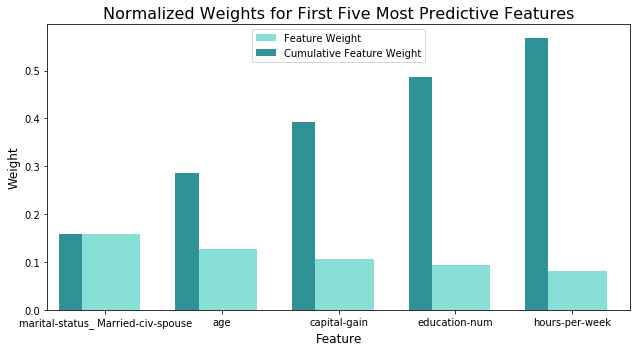

In [14]:
# TODO: Import a supervised learning model that has 'feature_importances_'

# TODO: Train the supervised model on the training set

# TODO: Extract the feature importances
importances= best_clf.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer**:

Three of the five features I thought would be the most important are represented on the graph above: age, capital gain and hours per week. Regarding education, I suspected that the education level would be an important feature. However, the feature education_num, which is the number of educational years completed by an individual, is actually more informative. One feature I had not expected to be important is the marital status: the graph shows that individuals who belong to the category Married-civ-spouse tend to earn more than 50K.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [16]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8677
F-score on testing data: 0.7508

Final Model trained on reduced data
------
Accuracy on testing data: 0.8485
F-score on testing data: 0.7013


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer**:

Training the final model with the top 5 features instead of the full set induces a decrease in both the accuracy and the F-score. While the drop in accuracy is relatively small (less than 2%), the F-score decreases by almost 5%. AdaBoost being computationally fast, I would argue that it is not worth decreasing the number of features at the expense of the F-score. However, if we had kept a Support Vector Machine, it might have made sense to try and speed up the training time by using less features.